In [1]:
import os
import django
from django.db import connection
import sys
import datetime
sys.path.append('../')
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
os.environ.setdefault('DJANGO_SETTINGS_MODULE', 'activity_viewer.settings')
django.setup()

In [2]:
from dashboard.models import Log, Item
from django.db.models import F, Count

In [31]:
download_requests = Log.objects.filter(http_status=200)
file_keys = list(Log.objects
             .values_list('s3_key', flat=True)
             .annotate(count=Count('ip_address', distinct=True))
             .order_by('-count'))[:16]
valid_ips = Log.objects.values_list('ip_address', flat=True).filter(s3_key__in=file_keys).distinct()

In [32]:
df = pd.DataFrame(0, index=file_keys, columns=file_keys)

In [33]:
for ip in valid_ips:
    downloaded = Log.objects.values_list('s3_key', flat=True).filter(s3_key__in=file_keys, ip_address=ip).distinct()
    for (key_1, key_2) in itertools.combinations(downloaded, 2):
        try:
            df.at[key_1, key_2] += 1
        except KeyError:
            pass

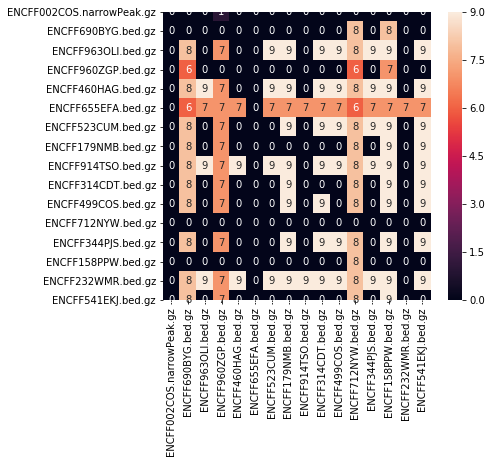

In [54]:
truncated_labels = [item.split('/')[-1] for item in file_keys]
axes = sns.heatmap(df, annot=True, xticklabels=truncated_labels, yticklabels=truncated_labels)
plt.subplots_adjust(bottom=0.0, top=1.0)
plt.savefig('bet.png', dpi=300)